# Dataset

## Loading Dataset

In [1]:
from datasets import load_dataset
from transformers import AutoTokenizer
import torch

# Caricamento del dataset
dataset = load_dataset("opus_books", "en-it")  # Dataset di traduzione inglese-italiano

# Divisione del dataset
from datasets import DatasetDict

# Dividere il dataset in train (80%) e test+validation (20%)
split_dataset = dataset['train'].train_test_split(test_size=0.2, seed=42)

# Dividere il dataset test+validation in test (10%) e validation (10%)
test_validation_split = split_dataset['test'].train_test_split(test_size=0.5, seed=42)

# Ricostruire il dataset diviso
final_dataset = DatasetDict({
    'train': split_dataset['train'],
    'validation': test_validation_split['train'],
    'test': test_validation_split['test']
})

# Verifica delle dimensioni dei dataset
print(final_dataset)



/home/enrico/Desktop/NLP-project/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 25865
    })
    validation: Dataset({
        features: ['id', 'translation'],
        num_rows: 3233
    })
    test: Dataset({
        features: ['id', 'translation'],
        num_rows: 3234
    })
})


## Preprocessing

In [2]:
from transformers import AutoTokenizer

# Tokenizzatori per inglese e italiano
tokenizer_en = AutoTokenizer.from_pretrained("bert-base-uncased")  # Tokenizzatore per inglese
tokenizer_it = AutoTokenizer.from_pretrained("dbmdz/bert-base-italian-uncased")  # Tokenizzatore per italiano

def preprocess_data_translation(example):
    max_input_length = 512
    max_output_length = 128

    # Tokenizzazione dell'input (inglese)
    inputs = tokenizer_en(example['translation']['en'], max_length=max_input_length, truncation=True, padding="max_length", return_tensors="pt")
    # Tokenizzazione del target (italiano)
    outputs = tokenizer_it(example['translation']['it'], max_length=max_output_length, truncation=True, padding="max_length", return_tensors="pt")
    
    return {
        "input_ids": inputs["input_ids"].squeeze(),
        "attention_mask": inputs["attention_mask"].squeeze(),
        "labels": outputs["input_ids"].squeeze()
    }

# Applicazione del preprocessamento
final_dataset = final_dataset.map(preprocess_data_translation)



Map: 100%|██████████| 3233/3233 [00:01<00:00, 2464.41 examples/s]


In [3]:
print(final_dataset)
print(final_dataset['train']['translation'][0])

DatasetDict({
    train: Dataset({
        features: ['id', 'translation', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 25865
    })
    validation: Dataset({
        features: ['id', 'translation', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 3233
    })
    test: Dataset({
        features: ['id', 'translation', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 3234
    })
})
{'en': 'He fell asleep in her arms.', 'it': 'Egli si addormentò fra le sue braccia.'}


# Model

## Structure

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Attenzione (Attention Mechanism)
class Attention(nn.Module):
    def __init__(self, hid_dim):
        super().__init__()
        self.attn = nn.Linear(hid_dim * 2, hid_dim)
        self.v = nn.Linear(hid_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        # hidden: (batch_size, hid_dim)
        # encoder_outputs: (batch_size, seq_len, hid_dim)
        
        src_len = encoder_outputs.shape[1]
        
        # Ripetiamo lo stato nascosto per il batch_size
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)  # (batch_size, seq_len, hid_dim)
        
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))  # (batch_size, seq_len, hid_dim)
        attention = self.v(energy).squeeze(2)  # (batch_size, seq_len)
        
        # Normalizza l'attenzione
        attention = torch.softmax(attention, dim=1)  # (batch_size, seq_len)
        
        # Calcola il contesto pesato
        weighted = torch.bmm(attention.unsqueeze(1), encoder_outputs)  # (batch_size, 1, hid_dim)
        weighted = weighted.squeeze(1)  # (batch_size, hid_dim)
        
        return weighted, attention

# Encoder migliorato con attenzione
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout, batch_first=True)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_mask):
        embedded = self.dropout(self.embedding(src))
        outputs, (hidden, cell) = self.rnn(embedded)
        return outputs, hidden, cell

# Decoder con attenzione migliorato
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim + hid_dim, hid_dim, n_layers, dropout=dropout, batch_first=True)
        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.attention = Attention(hid_dim)

    def forward(self, tgt, hidden, cell, encoder_outputs):
        embedded = self.dropout(self.embedding(tgt))
        
        # Applicazione dell'attenzione
        weighted, attention = self.attention(hidden[-1], encoder_outputs)  # hidden[-1] è lo stato nascosto finale
        
        # Ripetiamo il contesto 'weighted' per ogni elemento della sequenza del decoder
        weighted = weighted.unsqueeze(1).repeat(1, embedded.size(1), 1)  # (batch_size, seq_len, hid_dim)
        
        # Concatenazione tra embedded e weighted (attended context)
        rnn_input = torch.cat((embedded, weighted), dim=2)
        
        outputs, (hidden, cell) = self.rnn(rnn_input, (hidden, cell))
        predictions = self.fc_out(outputs)
        
        return predictions, hidden, cell, attention


# Modello Seq2Seq con attenzione
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, src_mask, tgt):
        encoder_outputs, hidden, cell = self.encoder(src, src_mask)
        outputs, hidden, cell, attention = self.decoder(tgt, hidden, cell, encoder_outputs)
        return outputs, attention


## Training

### Create DataLoader

In [13]:
from torch.nn.utils.rnn import pad_sequence

# Funzione per unire i dati in un batch con padding dinamico
def collate_fn(batch):
    # Estrai gli input, le maschere e le etichette
    input_ids = [torch.tensor(x['input_ids']) for x in batch]
    attention_mask = [torch.tensor(x['attention_mask']) for x in batch]
    labels = [torch.tensor(x['labels']) for x in batch]
    
    # Applica padding dinamico
    input_ids_padded = pad_sequence(input_ids, batch_first=True, padding_value=tokenizer_en.pad_token_id)
    attention_mask_padded = pad_sequence(attention_mask, batch_first=True, padding_value=0)
    labels_padded = pad_sequence(labels, batch_first=True, padding_value=tokenizer_it.pad_token_id)
    
    return {
        'input_ids': input_ids_padded,
        'attention_mask': attention_mask_padded,
        'labels': labels_padded
    }


### Create Model

In [17]:
from torch.utils.data import DataLoader
from tqdm import tqdm

import torch
torch.cuda.empty_cache()

import gc
gc.collect()

# Parametri del modello
INPUT_DIM = tokenizer_en.vocab_size
OUTPUT_DIM = tokenizer_it.vocab_size
EMB_DIM = 128
HID_DIM = 256
N_LAYERS = 2
DROPOUT = 0.5
LEARNING_RATE = 1e-3
BATCH_SIZE = 32
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Device: {DEVICE}")

# Inizializzazione del modello
encoder = Encoder(INPUT_DIM, EMB_DIM, HID_DIM, N_LAYERS, DROPOUT)
decoder = Decoder(OUTPUT_DIM, EMB_DIM, HID_DIM, N_LAYERS, DROPOUT)
model = Seq2Seq(encoder, decoder, DEVICE).to(DEVICE)



Device: cuda


### Load Weights

In [ ]:
# Carica i pesi salvati
model_to_load_name = "seq2seq.pt"
path = f"results/translation/{model_to_load_name}"
model.load_state_dict(torch.load(f"{path}"))
model.eval()  # Imposta il modello in modalità inferenza

/tmp/ipykernel_10079/1473672977.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{path}"))


Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(30522, 256)
    (rnn): LSTM(256, 512, num_layers=2, batch_first=True, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(30522, 256)
    (rnn): LSTM(256, 512, num_layers=2, batch_first=True, dropout=0.5)
    (fc_out): Linear(in_features=512, out_features=30522, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

### Training

In [19]:
# Ottimizzatore e funzione di perdita
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer_it.pad_token_id)

# Funzione di training
def train(model, dataloader, optimizer, criterion):
    model.train()
    epoch_loss = 0
    
    for batch in tqdm(dataloader):
        src = batch['input_ids'].to(DEVICE)
        src_mask = batch['attention_mask'].to(DEVICE)
        tgt = batch['labels'].to(DEVICE)

        optimizer.zero_grad()
        
        # Calcolo dell'output del modello
        output, attention = model(src, src_mask, tgt)
        
        # Shift dei target per evitare <sos>
        output_dim = output.shape[-1]
        output = output[:, :-1, :].contiguous().view(-1, output_dim)
        tgt = tgt[:, 1:].contiguous().view(-1)
        
        loss = criterion(output, tgt)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    return epoch_loss / len(dataloader)


from torch.utils.data import DataLoader

train_data_small = final_dataset['train'].select(range(2000))  # Limita il dataset a 1000 esempi

train_dataloader = DataLoader(train_data_small, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
validation_dataloader = DataLoader(final_dataset['validation'], batch_size=BATCH_SIZE, collate_fn=collate_fn)
test_dataloader = DataLoader(final_dataset['test'], batch_size=BATCH_SIZE, collate_fn=collate_fn)


train_losses = []

# Ciclo di addestramento
N_EPOCHS = 10
for epoch in range(N_EPOCHS):
    train_loss = train(model, train_dataloader, optimizer, criterion)
    train_losses.append(train_loss)  # Aggiungi la loss alla lista
    print(f'Epoch: {epoch+1}, Training Loss: {train_loss:.4f}')


100%|██████████| 63/63 [00:07<00:00,  8.76it/s]


Epoch: 1, Training Loss: 5.8418


100%|██████████| 63/63 [00:07<00:00,  8.86it/s]


Epoch: 2, Training Loss: 5.6204


100%|██████████| 63/63 [00:07<00:00,  8.85it/s]


Epoch: 3, Training Loss: 5.5020


100%|██████████| 63/63 [00:07<00:00,  8.89it/s]


Epoch: 4, Training Loss: 5.3963


100%|██████████| 63/63 [00:07<00:00,  8.89it/s]


Epoch: 5, Training Loss: 5.2856


100%|██████████| 63/63 [00:07<00:00,  8.82it/s]


Epoch: 6, Training Loss: 5.1989


100%|██████████| 63/63 [00:07<00:00,  8.83it/s]


Epoch: 7, Training Loss: 5.1070


100%|██████████| 63/63 [00:07<00:00,  8.87it/s]


Epoch: 8, Training Loss: 5.0221


100%|██████████| 63/63 [00:07<00:00,  8.86it/s]


Epoch: 9, Training Loss: 4.9433


100%|██████████| 63/63 [00:07<00:00,  8.83it/s]

Epoch: 10, Training Loss: 4.8610


Fine addestramento
Loss:  [5.841824130406455, 5.620384428236219, 5.501993852948385, 5.396285329546247, 5.285559631529308, 5.198901887923952, 5.107016063871837, 5.022099865807427, 4.94329805979653, 4.86102012604002]


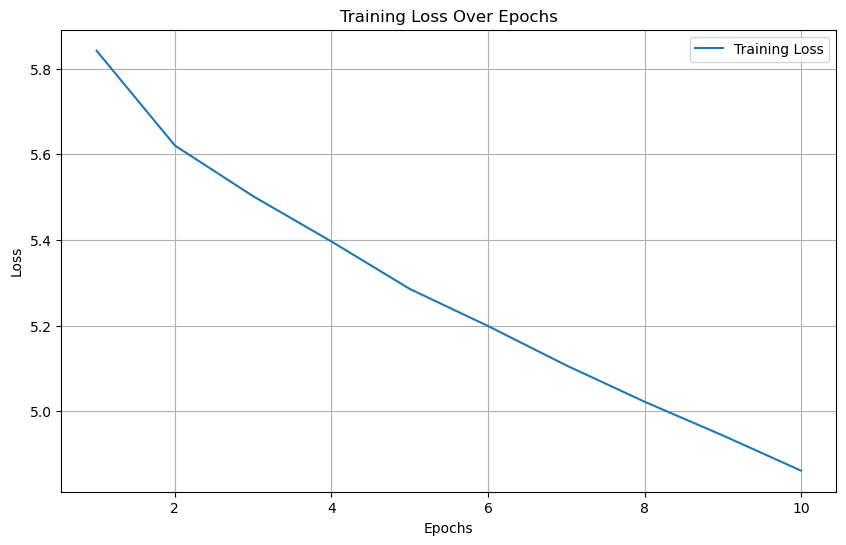

In [20]:
print("Fine addestramento")
print("Loss: ", train_losses)

# LOSS GRAPH
import matplotlib.pyplot as plt

# Plot della loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, N_EPOCHS + 1), train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.legend()
plt.show()

### Save model

In [ ]:
# Salvataggio del modello
model_name = "seq2seq-attention"
torch.save(model.state_dict(), f"./results/translation/{model_name}.pt")


# Inference

In [22]:
import torch.nn.functional as F

def translate(model, tokenizer_en, tokenizer_it, text):
    model.eval()
    tokens = tokenizer_en(text, return_tensors="pt", truncation=True, padding="max_length", max_length=512).to(DEVICE)
    src, src_mask = tokens['input_ids'], tokens['attention_mask']
    
    with torch.no_grad():
        encoder_outputs, hidden, cell = model.encoder(src, src_mask)
        tgt = torch.LongTensor([tokenizer_it.cls_token_id]).unsqueeze(0).to(DEVICE)
        outputs = []
        for _ in range(128):  # Limite alla lunghezza della traduzione
            prediction, hidden, cell, attention = model.decoder(tgt, hidden, cell, encoder_outputs)
            predicted_token = prediction.argmax(2)[:, -1].item()
            outputs.append(predicted_token)
            tgt = torch.cat([tgt, prediction.argmax(2)[:, -1].unsqueeze(0)], dim=1)
            if predicted_token == tokenizer_it.sep_token_id:
                break
    translation = tokenizer_it.decode(outputs, skip_special_tokens=True)
    return translation

# Test del traduttore
english_text = "This is a test sentence."
print(translate(model, tokenizer_en, tokenizer_it, english_text))


— e, e non posso nulla.


In [25]:
results = []
for example in validation_dataloader:
    article = tokenizer.decode(example["input_ids"], skip_special_tokens=True)
    summary = summarization_model(article, max_length=50, min_length=25, do_sample=False)
    results.append({"article": article, "summary": summary[0]["summary_text"]})

import json
with open("summaries.json", "w") as f:
    json.dump(results, f, indent=4)


TypeError: argument 'ids': 'list' object cannot be interpreted as an integer